In [19]:
import os, glob, shutil
import mne
import numpy as np
import scipy.io as io
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from mne.baseline import rescale
from mne.time_frequency import tfr_array_multitaper

In [20]:
# variables
subj = 'sub-001'
bids_dir = '/Users/knapen/projects/prf-seeg/data/bids'
derivatives_dir = '/Users/knapen/projects/prf-seeg/data/derivatives'
analysis_stage = 'preprocessing'

run = 3

In [21]:
edf_file = f'sub-001_run-{str(run).zfill(2)}_task-pRF_acq-2kHz.edf'
raw_data = mne.io.read_raw_edf(os.path.join(bids_dir, subj, 'func', edf_file))
# /Users/knapen/projects/prf-seeg/data/bids/sub-001/func/sub-001_run-03_task-pRF_acq-2kHz.edf

Extracting EDF parameters from /Users/knapen/projects/prf-seeg/data/bids/sub-001/func/sub-001_run-03_task-pRF_acq-2kHz.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


## Trigger Events
get the trigger events from the 'DC' channels

In [22]:
blank_channel = 8
bar_channel = 9

["mango" if i%3==0 else "orange" for i in range(10)]

dc_channels = [f'POL DC{str(i).zfill(2)}' for i in range(1,17)]
dc_channels_indx = [True if 'POL DC' in ch else False for ch in raw_data.ch_names]

In [23]:
raw_data.load_data()
raw_data.notch_filter([50,100,150], picks=np.arange(len(dc_channels_indx))[~np.array(dc_channels_indx)])
raw_data.resample(500, stim_picks=dc_channels_indx)

dc_data = raw_data.get_data(picks=dc_channels)

Reading 0 ... 1040031  =      0.000 ...   520.015 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 sec)



In [24]:
def timings_from_channel(channel_data, ll=4):
    baseline = np.median(channel_data)
    spread = np.std(channel_data)
    overs = channel_data > baseline+ll*spread
    onsets = np.r_[np.diff(overs)>0, False]
    onset_indx = np.arange(channel_data.shape[0])[onsets]
    return onsets, onset_indx


blank_onsets, blank_onset_indx = timings_from_channel(dc_data[blank_channel])
bar_onsets, bar_onset_indx = timings_from_channel(dc_data[bar_channel])

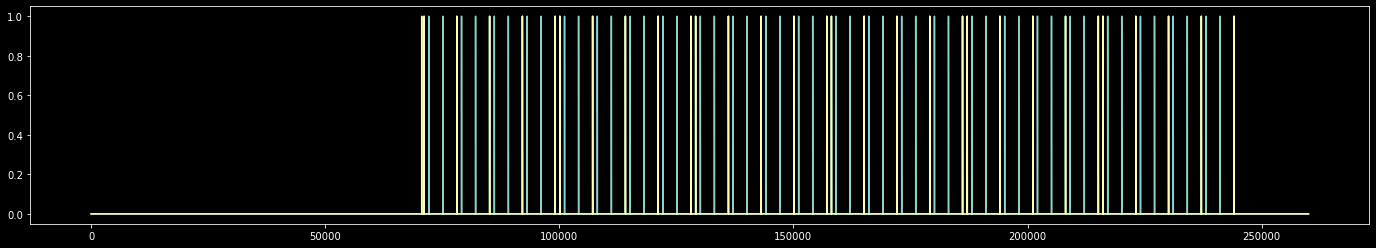

In [25]:
plt.figure(figsize=(24,4))
plt.plot(bar_onsets)
plt.plot(blank_onsets)
# plt.xlim([250000,1e6])

In [26]:
data_onset_idx = blank_onset_indx[0]
print(data_onset_idx)
# print(blank_onset_indx)

70603


## Now, get data from all other channels
the non-DC channels should contain signals

In [27]:
# raw_data.chnames
data_channels = [ch for ch in raw_data.ch_names if 'POL L' in ch]

# data_channels = [ch for ch in raw_data.ch_names if ch not in dc_channels]
raw_data_np = raw_data.get_data(picks=data_channels, start=data_onset_idx)

In [28]:
freqs = np.logspace(0.3,2.3,200)
# freqs = [15]
tfr_data = tfr_array_multitaper(raw_data_np[np.newaxis,...], sfreq=500, freqs=freqs, n_jobs=4, decim=5, output='power')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
tfr_data.shape

(1, 18, 200, 37910)

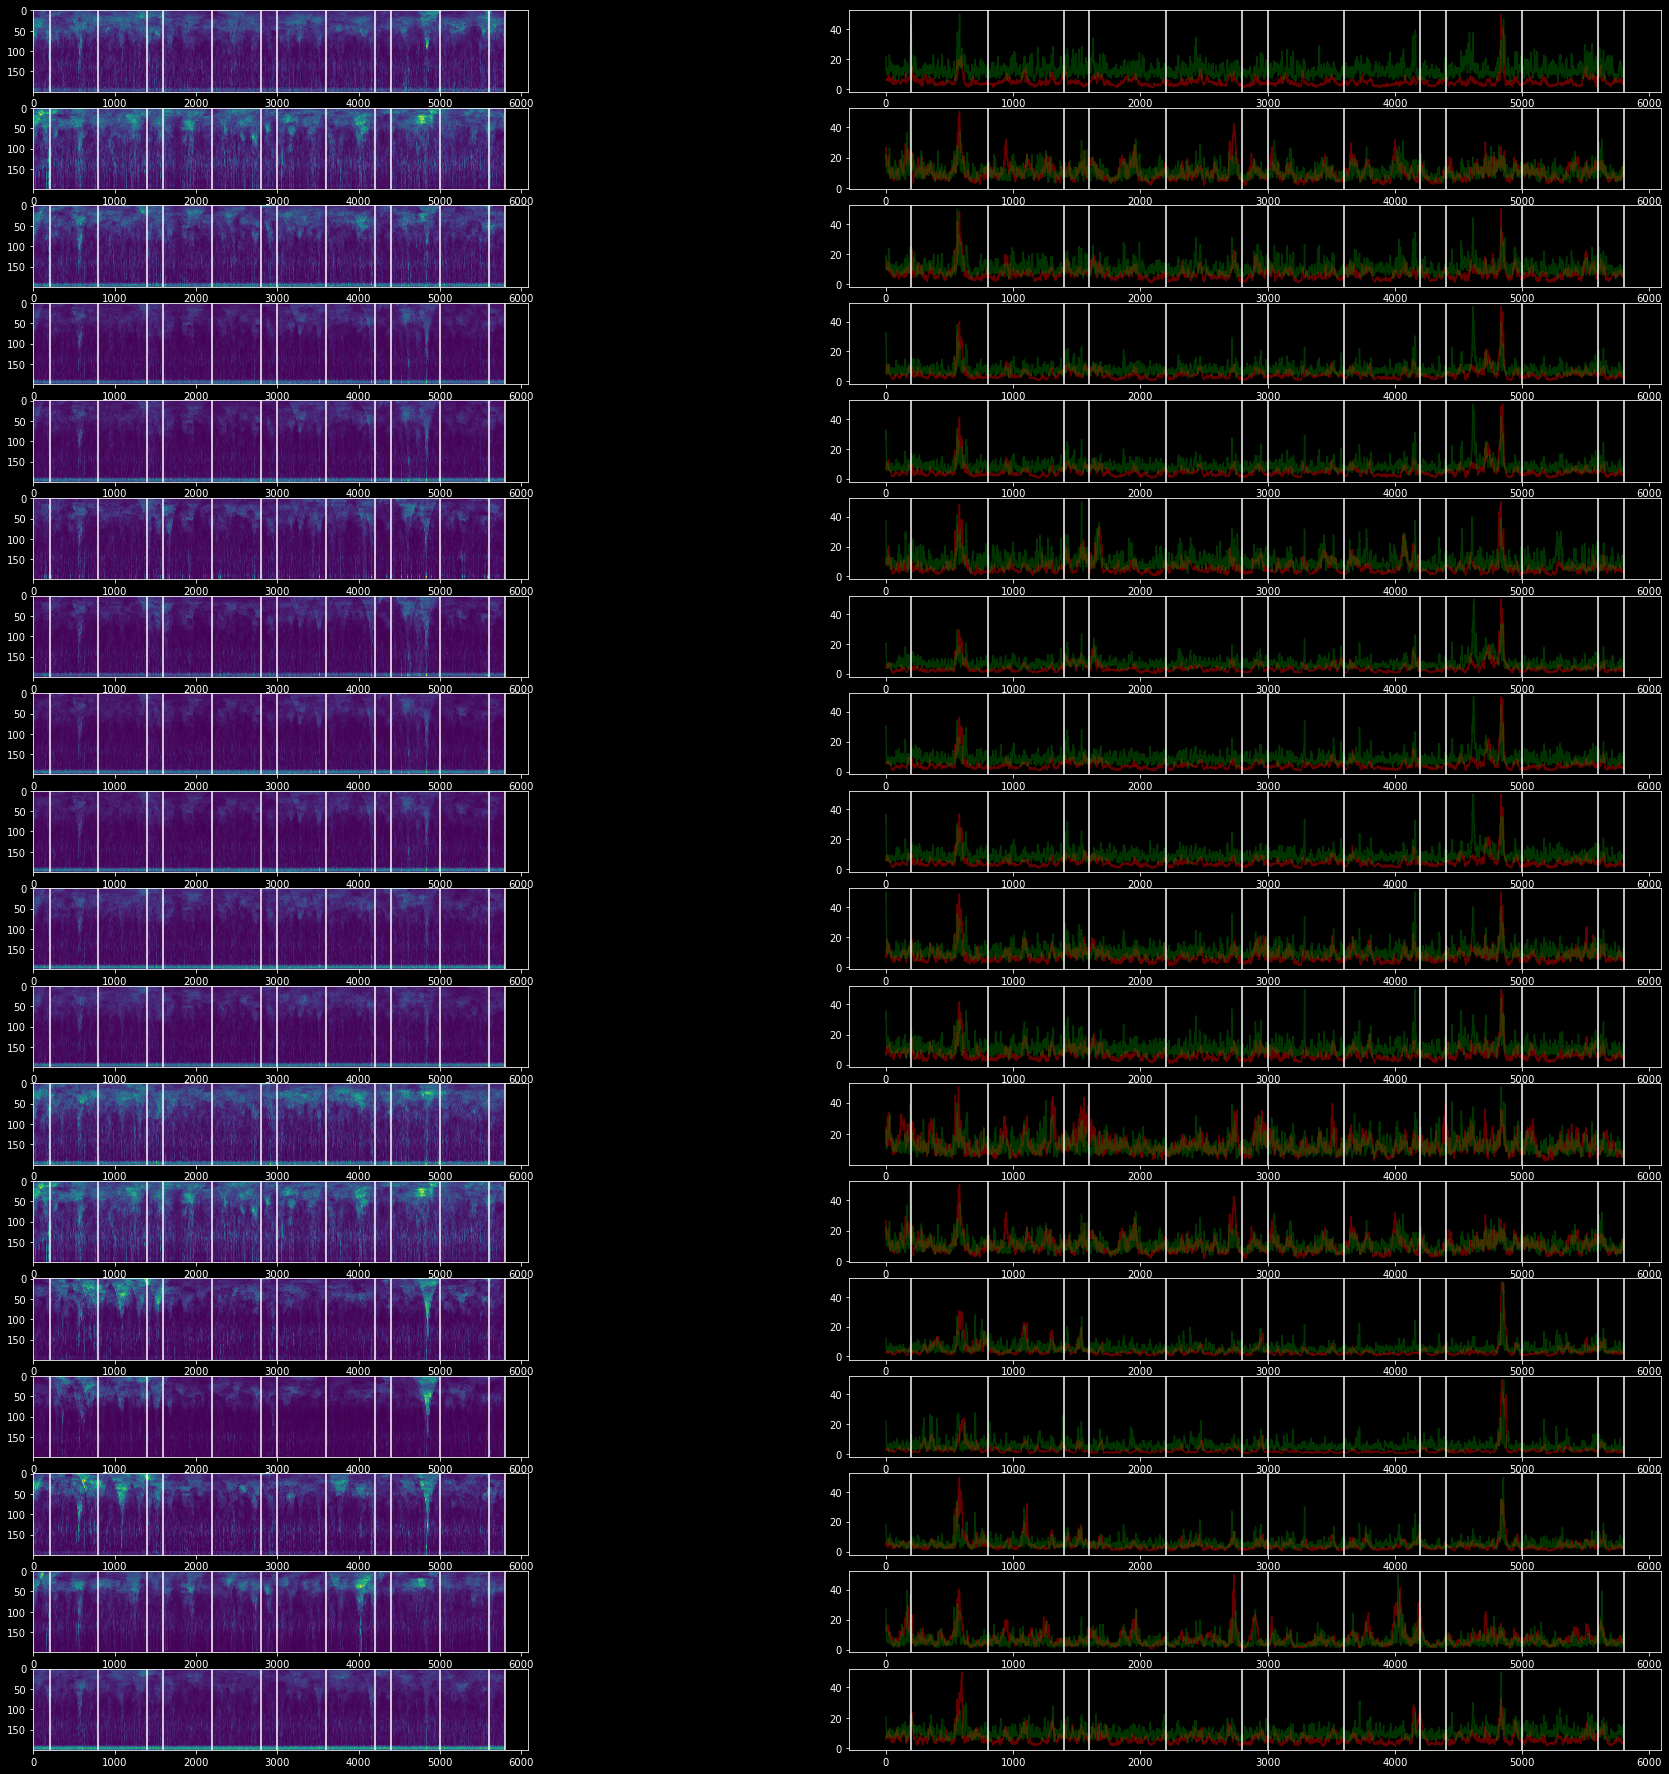

In [ ]:
# plt.plot(tfr_data[0,0,:,::10].T)
single_run_dur = int(58*500/5)
stim_frequencies = (freqs < 16) & (freqs > 14)
hg_frequencies = (freqs < 150) & (freqs > 50)

f, axs = plt.subplots(tfr_data.shape[1], 2, figsize=(32,32))
for k in range(tfr_data.shape[1]): # electrodes
    tfr_m = np.zeros((tfr_data.shape[2], single_run_dur))
    for i, ch in enumerate(tfr_data[0,k]): # frequencies
        rd = []
        for j in range(6): # stim repeats
            start_j = int(j*single_run_dur)
            rd.append(ch[start_j:start_j+single_run_dur])
        rd = np.array(rd)
        rd /= rd.std(1)[:,np.newaxis]
        tfr_m[i] = np.median(rd, 0)
    axs[k,0].imshow(tfr_m, aspect=5)
    stim_power = tfr_m[stim_frequencies].mean(0)
    stim_power /= stim_power.max()
    axs[k,1].plot(stim_power*50, 'r', alpha=0.4)
    hg_power = tfr_m[hg_frequencies].mean(0)
    hg_power /= hg_power.max()
    axs[k,1].plot(hg_power*50, 'g', alpha=0.4)
    

    for x in np.cumsum(np.array([200, 600, 600, 200, 600, 600, 200, 600, 600, 200, 600, 600, 200])):
        axs[k,0].axvline(x, c='w')
        axs[k,1].axvline(x, c='w')
plt.savefig(os.path.join(derivatives_dir, analysis_stage, subj, edf_file.replace('edf', 'pdf')))